In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [2]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return allsubs

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest'], subs)
print(X[0].shape)

847
(847, 264, 124)


In [3]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83
N = X[0].shape[0]

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [tr/20*N, 0.8*N], 2*N)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

ts = [np.stack([ts for ts in filter_design_ts(Xp)]) for Xp in X]
ts = np.stack(ts, axis=1)
ts = ts/np.linalg.norm(ts, axis=-1, keepdims=True)
print(ts.shape)

(847, 1, 264, 124)


In [8]:
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F

mask = (torch.ones(264,264)-torch.eye(264)).float().cuda()

class LowRankCodes(nn.Module):
    '''
    ranks: array of rank for each codebook matrix
    '''
    def __init__(self, ranks):
        super(LowRankCodes, self).__init__()
        self.As = []
        for rank in ranks:
            A = nn.Parameter(1e-2*torch.randn(rank,264).float().cuda())
            self.As.append(A)
        self.As = nn.ParameterList(self.As)

    def forward(self):
        book = []
        for A in self.As:
            AA = A.T@A
            AA = mask*AA
            book.append(AA)
        return torch.stack(book)
    
class LowRankWeights(nn.Module):
    '''
    nsubs: number of subjects
    nmods: number of modalities
    ncodes: number of pages in the codebook
    nt: number of timepoints
    '''
    def __init__(self, nsubs, nmods, ncodes, nt):
        super(LowRankWeights, self).__init__()
        self.w = nn.Parameter(1e-2*torch.rand(nsubs, nmods, ncodes, nt).float().cuda())
        
#     def features(self, vecbook):
#         w = F.relu(self.w)
#         return torch.einsum('nr,ra->nra',w,vecbook).reshape(w.shape[0],-1)

    def forward(self, sub, book, mod):
        w = self.w[sub,mod]
        return torch.einsum('pt,pab->abt', w, book)
    
def get_recon_loss(x, xhat):
    return mseLoss(xhat, x)

def get_smooth_loss_fc(xhat):
    before = xhat[:,:,:-1]
    after = xhat[:,:,1:]
    return torch.mean((before-after)**2)

def get_smooth_loss_w(w, mod):
    before = w[:,mod,:,:-1]
    after = w[:,mod,:,1:]
    return torch.mean((before-after)**2)

def get_sub_fc(subts):
    return torch.einsum('at,bt->abt',subts,subts)*mask.unsqueeze(2)
    
x = torch.from_numpy(ts).float().cuda()
    
ntrain = 400
nbatch = 30
smooth_mult = 0.5
nEpochs = 50
pPeriod = 40

mseLoss = nn.MSELoss()
    
lrc = LowRankCodes(300*[1])
ncodes = len(lrc.As)

lrw = LowRankWeights(ntrain, 1, ncodes, x.shape[-1])

optim = torch.optim.Adam(
    [
        {'params': lrc.parameters(), 'lr': 1e-2, 'weight_decay': 0},
        {'params': lrw.parameters(), 'lr': 1e-2, 'weight_decay': 0},
    ]
)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=int(ntrain/nbatch)+5, factor=0.75, eps=1e-7)
    
for epoch in range(nEpochs):
    suborder = np.arange(ntrain)
#     np.random.shuffle(suborder)
    for bstart in range(0,ntrain,nbatch):
        bend = bstart+nbatch
        if bend > ntrain:
            bend = ntrain
        optim.zero_grad()
        book = lrc()
        recon_loss = 0
        smooth_loss_fc = 0
        for subidx in range(bstart, bend):
            sub = suborder[subidx]
            xsub = get_sub_fc(x[sub, 0])
            xhat = lrw(sub, book, 0)
            recon_loss += get_recon_loss(xsub, xhat)
            smooth_loss_fc += smooth_mult*get_smooth_loss_fc(xhat)
        recon_loss /= (bend-bstart)
        smooth_loss_fc /= (bend-bstart)
        totloss = recon_loss+smooth_loss_fc
        totloss.backward()
        optim.step()
        sched.step(totloss)
        if bstart % nbatch == 0:
            print(f'{epoch} {bstart} recon: {[float(ls)**0.5 for ls in [recon_loss, smooth_loss_fc]]} '
                  f'lr: {sched._last_lr}')

print('Complete')

0 0 recon: [0.012099895015944103, 4.972764597309851e-06] lr: [0.01, 0.01]
0 30 recon: [0.011736983528618489, 4.971075377907714e-06] lr: [0.01, 0.01]
0 60 recon: [0.012878534352648982, 4.9751595383944495e-06] lr: [0.01, 0.01]
0 90 recon: [0.012705812903032887, 4.98595263260938e-06] lr: [0.01, 0.01]
0 120 recon: [0.01424909124491591, 4.994158409101758e-06] lr: [0.01, 0.01]
0 150 recon: [0.013201201235444625, 5.0082867058954175e-06] lr: [0.01, 0.01]
0 180 recon: [0.011583219421217216, 5.0324280530568904e-06] lr: [0.01, 0.01]
0 210 recon: [0.012542772176981848, 5.061841434273181e-06] lr: [0.01, 0.01]
0 240 recon: [0.012850636532942852, 5.100017318733432e-06] lr: [0.01, 0.01]
0 270 recon: [0.013082552519199177, 5.156629735801651e-06] lr: [0.01, 0.01]
0 300 recon: [0.012033581487479064, 5.233954816633761e-06] lr: [0.01, 0.01]
0 330 recon: [0.012510462965018204, 5.325741576116212e-06] lr: [0.01, 0.01]
0 360 recon: [0.012248177918556005, 5.430516936472691e-06] lr: [0.01, 0.01]
0 390 recon: [0.

7 330 recon: [0.010724077822628296, 0.0019312271656274451] lr: [0.0075, 0.0075]
7 360 recon: [0.010717251605818589, 0.002084445301064009] lr: [0.0075, 0.0075]
7 390 recon: [0.013133651458360608, 0.006204236579877758] lr: [0.0075, 0.0075]
8 0 recon: [0.010469581719753937, 0.002345288164333711] lr: [0.0075, 0.0075]
8 30 recon: [0.00998266224391222, 0.0026254613227133716] lr: [0.0075, 0.0075]
8 60 recon: [0.010871338077530514, 0.0030571704786505516] lr: [0.005625, 0.005625]
8 90 recon: [0.010855968935164743, 0.002958102038396119] lr: [0.005625, 0.005625]
8 120 recon: [0.012210200017679718, 0.003166333448462462] lr: [0.005625, 0.005625]
8 150 recon: [0.011285384556216102, 0.002904002967201991] lr: [0.005625, 0.005625]
8 180 recon: [0.009789887478242327, 0.002468956440019188] lr: [0.005625, 0.005625]
8 210 recon: [0.010853260547309352, 0.002224159989039141] lr: [0.005625, 0.005625]
8 240 recon: [0.011285396161241084, 0.002117307116366031] lr: [0.005625, 0.005625]
8 270 recon: [0.01124038012

14 360 recon: [0.009905115062244244, 0.0029325413897667947] lr: [0.005625, 0.005625]
14 390 recon: [0.011128765864003975, 0.0048803850562447884] lr: [0.005625, 0.005625]
15 0 recon: [0.009871290794879879, 0.0027314343742852526] lr: [0.005625, 0.005625]
15 30 recon: [0.009522978194747723, 0.0026200810344287314] lr: [0.005625, 0.005625]
15 60 recon: [0.010316771353404646, 0.0030117886502847354] lr: [0.005625, 0.005625]
15 90 recon: [0.010157279589395126, 0.0030338493544564862] lr: [0.005625, 0.005625]
15 120 recon: [0.011570758459877678, 0.003248995123280279] lr: [0.005625, 0.005625]
15 150 recon: [0.010635889402171387, 0.0029249716779816055] lr: [0.005625, 0.005625]
15 180 recon: [0.009321332001474794, 0.0025710744742664816] lr: [0.005625, 0.005625]
15 210 recon: [0.010208492671752318, 0.002707478864882944] lr: [0.005625, 0.005625]
15 240 recon: [0.010710360917100623, 0.002673252452794757] lr: [0.005625, 0.005625]
15 270 recon: [0.010375019688522051, 0.0030587531916850385] lr: [0.005625

21 240 recon: [0.010417765724544588, 0.002888717758162186] lr: [0.0031640625, 0.0031640625]
21 270 recon: [0.010044493053528806, 0.0033173485358709547] lr: [0.0031640625, 0.0031640625]
21 300 recon: [0.009633970553157522, 0.0027873630999017524] lr: [0.0031640625, 0.0031640625]
21 330 recon: [0.009341294793303267, 0.003318365251165537] lr: [0.0031640625, 0.0031640625]
21 360 recon: [0.009609192881854918, 0.003045666396952198] lr: [0.0031640625, 0.0031640625]
21 390 recon: [0.010566700408599288, 0.004506892282910215] lr: [0.0031640625, 0.0031640625]
22 0 recon: [0.009554722812811325, 0.0029375170664266955] lr: [0.0031640625, 0.0031640625]
22 30 recon: [0.009221976002922856, 0.0028605292212128593] lr: [0.0031640625, 0.0031640625]
22 60 recon: [0.009979175864842291, 0.0032903698850486034] lr: [0.0031640625, 0.0031640625]
22 90 recon: [0.00981988510410572, 0.0033265858025047397] lr: [0.0031640625, 0.0031640625]
22 120 recon: [0.01102844219702836, 0.00358020808199271] lr: [0.0031640625, 0.00

28 0 recon: [0.009320886285011886, 0.003143726015873378] lr: [0.0031640625, 0.0031640625]
28 30 recon: [0.009024609524711551, 0.003011445130421176] lr: [0.0031640625, 0.0031640625]
28 60 recon: [0.009739364019305578, 0.0034667499097896784] lr: [0.0031640625, 0.0031640625]
28 90 recon: [0.009559809446388326, 0.0035355674314515063] lr: [0.0031640625, 0.0031640625]
28 120 recon: [0.010616725004439687, 0.0038014226255874747] lr: [0.0031640625, 0.0031640625]
28 150 recon: [0.009954156302909066, 0.0034636318139941807] lr: [0.0031640625, 0.0031640625]
28 180 recon: [0.008803022080530081, 0.0029646321747825934] lr: [0.0031640625, 0.0031640625]
28 210 recon: [0.009553618568509841, 0.0031799148574686406] lr: [0.0031640625, 0.0031640625]
28 240 recon: [0.010092292236318443, 0.003158004337032314] lr: [0.0031640625, 0.0031640625]
28 270 recon: [0.009725594057637446, 0.003584903362628413] lr: [0.0031640625, 0.0031640625]
28 300 recon: [0.00934366508225719, 0.0030372224298264947] lr: [0.0031640625, 0

34 180 recon: [0.008641549833192262, 0.003066826661477139] lr: [0.0031640625, 0.0031640625]
34 210 recon: [0.009329122743070396, 0.0033289911425485514] lr: [0.0031640625, 0.0031640625]
34 240 recon: [0.009870154885092396, 0.003305612373335317] lr: [0.0031640625, 0.0031640625]
34 270 recon: [0.009539742570319745, 0.0036930692817646934] lr: [0.0031640625, 0.0031640625]
34 300 recon: [0.009144330637610143, 0.0031686793227272392] lr: [0.0031640625, 0.0031640625]
34 330 recon: [0.008897903417013993, 0.0037120522923337184] lr: [0.0031640625, 0.0031640625]
34 360 recon: [0.009194192418651177, 0.0033627367794224552] lr: [0.0031640625, 0.0031640625]
34 390 recon: [0.009794294102685897, 0.005210215972103218] lr: [0.0031640625, 0.0031640625]
35 0 recon: [0.009134467245341333, 0.0032562543044124316] lr: [0.0031640625, 0.0031640625]
35 30 recon: [0.008860374107729477, 0.003114548765327676] lr: [0.0031640625, 0.0031640625]
35 60 recon: [0.009538732702629234, 0.003568300503354165] lr: [0.0031640625, 

40 360 recon: [0.009136309852018729, 0.0033096255548161787] lr: [0.0031640625, 0.0031640625]
40 390 recon: [0.010175403386717814, 0.006361550703991936] lr: [0.0031640625, 0.0031640625]
41 0 recon: [0.009078649707222145, 0.003207252240091973] lr: [0.0031640625, 0.0031640625]
41 30 recon: [0.00880045698571083, 0.0031005002194386716] lr: [0.0031640625, 0.0031640625]
41 60 recon: [0.009476887741609602, 0.003529005413412756] lr: [0.0031640625, 0.0031640625]
41 90 recon: [0.009315409492057282, 0.0035644429493295097] lr: [0.0031640625, 0.0031640625]
41 120 recon: [0.01012181704450908, 0.004042027733658707] lr: [0.0031640625, 0.0031640625]
41 150 recon: [0.009622127533950323, 0.0036232610073955304] lr: [0.0031640625, 0.0031640625]
41 180 recon: [0.00854382678235402, 0.0030869381403066973] lr: [0.0031640625, 0.0031640625]
41 210 recon: [0.009206610038667793, 0.0033422897101897902] lr: [0.0031640625, 0.0031640625]
41 240 recon: [0.009719577647792849, 0.0033329370159863587] lr: [0.0031640625, 0.0

47 120 recon: [0.00994212861799795, 0.004166696839468581] lr: [0.0031640625, 0.0031640625]
47 150 recon: [0.009495387626970313, 0.0036952593332746256] lr: [0.0031640625, 0.0031640625]
47 180 recon: [0.00844435650353824, 0.003135851405271575] lr: [0.0031640625, 0.0031640625]
47 210 recon: [0.009078331130782874, 0.0034232466045607856] lr: [0.0031640625, 0.0031640625]
47 240 recon: [0.009568925724834247, 0.0034130985876883796] lr: [0.0031640625, 0.0031640625]
47 270 recon: [0.009328482407812689, 0.0037363832718666176] lr: [0.0031640625, 0.0031640625]
47 300 recon: [0.008909555599341113, 0.003249786252147694] lr: [0.0031640625, 0.0031640625]
47 330 recon: [0.008767783960910876, 0.0036589364124407667] lr: [0.0031640625, 0.0031640625]
47 360 recon: [0.009008306429632363, 0.0033982303827489384] lr: [0.0031640625, 0.0031640625]
47 390 recon: [0.009901699110074163, 0.006328418929616204] lr: [0.0031640625, 0.0031640625]
48 0 recon: [0.008947364101271853, 0.0033168832483865558] lr: [0.0031640625,

/tmp/ipykernel_64809/1002927163.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


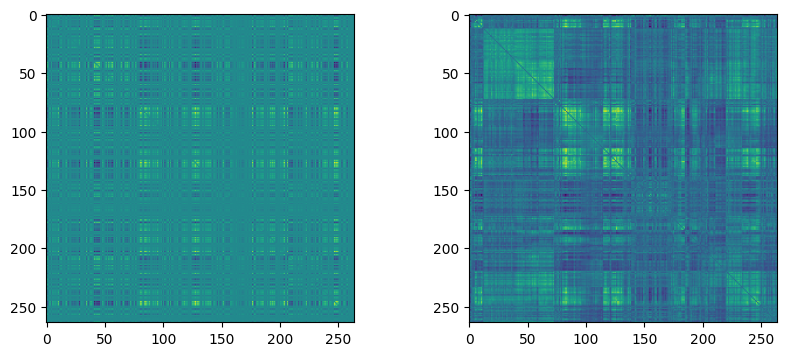

In [10]:
import matplotlib.pyplot as plt

def get_imgs(sub, t=None):
    with torch.no_grad():
        book = lrc()
        xsub = get_sub_fc(x[sub, 0])
        xhat = lrw(sub, book, 0)
        pair = [xsub, xhat]
    pair = [p.detach().cpu().numpy() for p in pair]
    if t is None:
        pair = [np.mean(p, axis=-1) for p in pair]
    else:
        pair = [p[:,:,t] for p in pair]
    return pair

fig, ax = plt.subplots(1,2,figsize=(10,4))

xsub, xhat = get_imgs(9,5)
    
ax[0].imshow(xsub)
ax[1].imshow(xhat)
fig.show()

In [11]:
with open('/home/anton/Documents/Tulane/Research/Work/LatSimEC/DynFC/book_rest_400-300-1-0p5.pkl', 'wb') as f:
    As = []
    for A in lrc.As:
        As.append(A.detach().cpu().numpy())
    pickle.dump(As, f)
    
print('Complete')

Complete


In [238]:
# Estimate weights

nEpochs = 500
pPeriod = 100

book = lrc().detach().clone()
book.grad = None

lrw2 = LowRankWeights(tstr_in.shape[0], tstr_out.shape[1], nCodes, nw)
optim = torch.optim.Adam(lrw2.parameters(), lr=1e-1, weight_decay=0)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.95, eps=1e-7)

for epoch in range(nEpochs):
    for i in range(1):
        optim.zero_grad()
        xhat = lrw2(tstr_in[:,i], book, i)
        xloss = mseLoss(xhat, tstr_out[:,i])
        xloss.backward()
        optim.step()
        sched.step(xloss)
        if epoch % pPeriod == 0 or epoch == nEpochs-1:
            print(f'{epoch} recon: {float(xloss**0.5)} lr: {float(sched._last_lr[0])}')

print('Complete')

0 recon: 97.65791320800781 lr: 0.1
100 recon: 6.755094051361084 lr: 0.08145062499999998
200 recon: 6.443493843078613 lr: 0.08145062499999998
300 recon: 6.369539737701416 lr: 0.08145062499999998
400 recon: 6.343796253204346 lr: 0.08145062499999998
499 recon: 6.331742286682129 lr: 0.08145062499999998
Complete


In [239]:
import torch
import torch.nn as nn
import torch.nn.functional as F

xec = lrw2.w[:,0].reshape(lrw2.w.shape[0],-1)
xectr = xec[:600]
xect = xec[600:]

y = get_y(metadict, ['age'], subs)[0]
y_t = torch.from_numpy(y).float().cuda()
ytr = y_t[:600]
yt = y_t[600:]

print(xec.shape)
print(xectr.shape)
print(xect.shape)
print(y.shape)

torch.Size([847, 200])
torch.Size([600, 200])
torch.Size([247, 200])
(847,)


In [240]:
mseLoss = nn.MSELoss()

w, _, _, _ = torch.linalg.lstsq(xectr, ytr)
yhattr = xectr@w
yhatt = xect@w
print(mseLoss(yhattr, ytr)**0.5)
print(mseLoss(yhatt, yt)**0.5)

tensor(29.0802, device='cuda:0', grad_fn=<PowBackward0>)
tensor(45.0205, device='cuda:0', grad_fn=<PowBackward0>)


In [241]:
class MLP(nn.Module):
    def __init__(self, dim):
        super(MLP, self).__init__()
        self.l0 = nn.Linear(dim,30).float().cuda()
        self.l1 = nn.Linear(30,1).float().cuda()
        
    def forward(self, x):
        y = F.relu(self.l0(x))
        y = self.l1(y).squeeze()
        return y

mseLoss = nn.MSELoss()
    
mlp = MLP(xec.shape[1])
optim = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e0)

nEpochs = 10000
pPeriod = 1000

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)

for epoch in range(nEpochs):
    optim.zero_grad()
    yhat = mlp(xectr)
    loss = mseLoss(yhat, ytr)
#     l1loss = 1e0*(torch.sum(torch.abs(mlp.l0.weight))+torch.sum(torch.abs(mlp.l0.bias)))
    loss.backward()
    optim.step()
    sched.step(loss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(loss)**0.5} lr: {sched._last_lr}')
        
print('Complete')
print(mseLoss(mlp(xect), yt)**0.5)

0 184.54291082970377 lr: [0.001]
1000 75.82232778426814 lr: [0.001]
2000 37.87341909602878 lr: [0.001]
3000 31.338012778762394 lr: [0.001]
4000 28.669798332492352 lr: [0.001]
5000 27.28739617013858 lr: [0.001]
6000 26.43929492096884 lr: [0.001]
7000 25.86838140932442 lr: [0.001]
8000 25.41327955679926 lr: [0.001]
9000 25.118618738382466 lr: [0.001]
9999 24.979149019576056 lr: [0.0003584859224085418]
Complete
tensor(36.4105, device='cuda:0', grad_fn=<PowBackward0>)


In [242]:
import sys 

sys.path.append('../../LatentSimilarity')

from latsim import LatSim

print('Complete')

Complete


In [244]:
sim = LatSim(1, xec.unsqueeze(1), dp=0.5, edp=0, wInit=1e-4, dim=10, temp=10)
optim = torch.optim.Adam(sim.parameters(), lr=1e-3, weight_decay=1e-3)

nEpochs = 1000
pPeriod = 100

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)

for epoch in range(nEpochs):
    optim.zero_grad()
    yhat = sim(xectr.unsqueeze(1), [ytr])[0][0]
    loss = mseLoss(yhat, ytr)
    loss.backward()
    optim.step()
    sched.step(loss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(loss)**0.5} lr: {sched._last_lr}')
        
print('Complete')

print(mseLoss(sim(xec.unsqueeze(1), [y_t], torch.arange(600,y_t.shape[0]))[0][0][600:], yt)**0.5)

0 40.081035164810956 lr: [0.001]
100 39.012242669769705 lr: [0.001]
200 36.265906060414544 lr: [0.00095]
300 35.12271664620172 lr: [0.0006983372960937497]
400 34.958090840810726 lr: [0.00046329123015975297]
500 34.14083595472583 lr: [0.00030735686772502346]
600 33.62322471498495 lr: [0.00021463876394293716]
700 33.7593809300652 lr: [0.00014239574134637458]
800 34.44626667849417 lr: [8.974483193085068e-05]
900 34.228330565209426 lr: [5.373354598274025e-05]
999 34.26560540640115 lr: [3.3865535638032174e-05]
Complete
tensor(37.0512, device='cuda:0', grad_fn=<PowBackward0>)
